# 1. Target and Features

## Import Libraries

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import talib as ta
from statsmodels.tsa.stattools import adfuller

## Read the Data

In [50]:
# Read the data
data = pd.read_csv('JPM_2017_2019.csv', index_col=0)
data.index = pd.to_datetime(data.index)

## Target Variable

In [51]:
# Create a column 'future_returns' with the calculation of percentage change
data['future_returns'] = data['close'].pct_change().shift(-1)

# Create the signal column
data['signal'] = np.where(data['future_returns'] > 0, 1, 0)

data.head()

,open,high,low,close,volume,future_returns,signal
2017-01-03 09:45:00+00:00,87.34,87.75,87.02,87.39,2184761.0,-0.002289,0
2017-01-03 10:00:00+00:00,87.39,87.44,86.95,87.19,1148228.0,0.001262,1
2017-01-03 10:15:00+00:00,87.21,87.41,87.14,87.30,860609.0,0.000916,1
2017-01-03 10:30:00+00:00,87.31,87.38,87.26,87.38,481605.0,-0.002861,0
2017-01-03 10:45:00+00:00,87.37,87.46,87.13,87.13,675950.0,-0.006312,0


## Features

In [52]:
# Create a column 'pct_change' with the 15-minute prior percentage change
data['pct_change'] = data['close'].pct_change()

# Create a column 'pct_change2' with the half an hour prior percentage change
data['pct_change2'] = data['close'].pct_change(2)

# Create a column 'pct_change5' with the 75-minute prior percentage change
data['pct_change5'] = data['close'].pct_change(5)

In [53]:
# Create a column by the name RSI, and assign the RSI values to it
data['rsi'] = ta.RSI(data['close'].values, timeperiod=int(6.5*4))

# Create a column by the name ADX, and assign the ADX values to it
data['adx'] = ta.ADX(data['high'].values, data['low'].values,
                     data['open'].values, timeperiod=int(6.5*4))

In [54]:
# Create a column by the name sma, and assign the SMA values to it
data['sma'] = data['close'].rolling(window=int(6.5*4)).mean()

# Create a column by the name corr, and assign the correlation values to it
data['corr'] = data['close'].rolling(window=int(6.5*4)).corr(data['sma'])

In [55]:
# 1-day and 2-day volatility
data['volatility'] = data.rolling(
    int(6.5*4), min_periods=int(6.5*4))['pct_change'].std()*100

data['volatility2'] = data.rolling(
    int(6.5*8), min_periods=int(6.5*8))['pct_change'].std()*100

data.tail()

,open,high,low,close,volume,future_returns,signal,pct_change,pct_change2,pct_change5,rsi,adx,sma,corr,volatility,volatility2
2019-12-31 15:00:00+00:00,138.720,138.786,138.720,138.755,137277.0,0.000144,1,0.000108,-0.000900,0.000108,48.917663,18.059900,138.707846,-0.233961,0.076398,0.110535
2019-12-31 15:15:00+00:00,138.745,138.787,138.655,138.775,139979.0,0.000973,1,0.000144,0.000252,-0.000547,49.359122,18.104801,138.705885,-0.348533,0.073904,0.110430
2019-12-31 15:30:00+00:00,138.760,138.930,138.704,138.910,144914.0,0.002088,1,0.000973,0.001117,0.000720,52.255662,17.906918,138.707615,-0.538080,0.076218,0.111184
2019-12-31 15:45:00+00:00,138.910,139.220,138.883,139.200,336305.0,0.001365,1,0.002088,0.003063,0.002304,57.665344,17.283036,138.729346,-0.511921,0.078749,0.114850
2019-12-31 16:00:00+00:00,139.195,139.480,139.140,139.390,949197.0,NaN,0,0.001365,0.003455,0.004685,60.699494,16.886426,138.757038,-0.466739,0.082235,0.115960


## Create X and y

In [56]:
# Drop the missing values
data.dropna(inplace=True)

In [57]:
# Target
y = data[['signal']].copy()

# Features
X = data[['pct_change', 'pct_change2', 'pct_change5', 'rsi',
       'adx', 'sma', 'corr', 'volatility', 'volatility2']].copy()

### Stationarity Check

In [58]:
def stationary(series):
    """Function to check if the series is stationary or not.
    """

    result = adfuller(series)
    if(result[1] < 0.05):
        return 'stationary'
    else:
        return 'not stationary'


# Check for stationarity
for col in X.columns:
    if stationary(data[col]) == 'not stationary':
        print('%s is not stationary. Dropping it.' % col)
        X.drop(columns=[col], axis=1, inplace=True)
    else:
        print('%s is stationary.' % col)

pct_change is stationary.
pct_change2 is stationary.
pct_change5 is stationary.
rsi is stationary.
adx is stationary.
sma is not stationary. Dropping it.
corr is stationary.
volatility is stationary.
volatility2 is stationary.


### Correlation Check

In [59]:
def get_pair_above_threshold(X, threshold):
    """Function to return the pairs with correlation above threshold.
    """
    # Calculate the correlation matrix
    correl = X.corr()

    # Unstack the matrix
    correl = correl.abs().unstack()

    # Recurring & redundant pair
    pairs_to_drop = set()
    cols = X.corr().columns
    for i in range(0, X.corr().shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))

    # Drop the recurring & redundant pair
    correl = correl.drop(labels=pairs_to_drop).sort_values(ascending=False)

    return correl[correl > threshold].index


print(get_pair_above_threshold(X, 0.7))

MultiIndex([('volatility', 'volatility2')],
           )


In [60]:
# Drop the highly correlated column
X = X.drop(columns=['volatility2'], axis=1)

## Display the Final Features

In [61]:
X.head()

,pct_change,pct_change2,pct_change5,rsi,adx,corr,volatility
2017-01-05 09:45:00+00:00,-0.000115,-0.000920,-0.000920,46.849667,9.932116,0.795243,0.112499
2017-01-05 10:00:00+00:00,-0.003108,-0.003222,-0.003910,42.011647,10.304958,0.702034,0.092029
2017-01-05 10:15:00+00:00,-0.002425,-0.005525,-0.005639,38.772892,10.916288,0.506866,0.103320
2017-01-05 10:30:00+00:00,-0.000347,-0.002771,-0.006785,38.333830,11.716813,0.313286,0.103321
2017-01-05 10:45:00+00:00,-0.003358,-0.003704,-0.009322,34.415816,12.622385,0.073429,0.122080


### Save the Files on Your Disk

In [62]:
# Convert the features to CSV
X.to_csv("JPM_features_2017_2019.csv")

# Convert the target to CSV
y.to_csv("JPM_target_2017_2019.csv")

# 2. Train - Test Split

## Import Libraries

In [63]:
# For data manipulation
import pandas as pd

# Import sklearn's train-test split module
from sklearn.model_selection import train_test_split

# For plotting
import matplotlib.pyplot as plt

## Read the Data

In [64]:
# Read the features
X = pd.read_csv('JPM_features_2017_2019.csv',
                index_col=0, parse_dates=True)

# Read the target
y = pd.read_csv('JPM_target_2017_2019.csv',
                index_col=0, parse_dates=True)

## Train-Test Split

In [65]:
# Obtain the features and target for the `train_data` and `test_data`
# The features (X) and the target (y) is passed along with the size of the train_data as a percentage of the total data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80)

# Print the dimensions of the variables
print(f"The shape of the X variable is {X.shape}.")
print(f"The shape of the y variable is {y.shape}. \n")
print(f"The shape of the X_train variable is {X_train.shape}.")
print(f"The shape of the y_train variable is {y_train.shape}.\n")
print(f"The shape of the X_test variable is {X_test.shape}.")
print(f"The shape of the y_test variable is {y_test.shape}.\n")

The shape of the X variable is (19317, 7).
The shape of the y variable is (19317, 1). 

The shape of the X_train variable is (15453, 7).
The shape of the y_train variable is (15453, 1).

The shape of the X_test variable is (3864, 7).
The shape of the y_test variable is (3864, 1).



## Visualise the Data

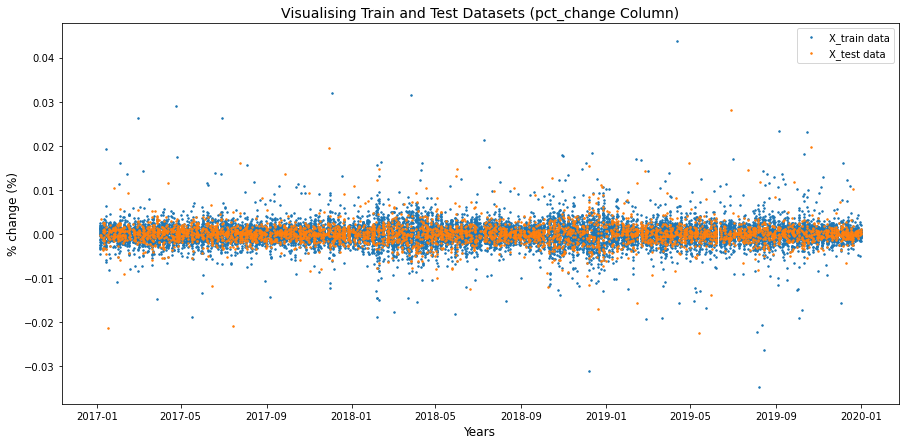

In [66]:
# Plot the data
plt.figure(figsize=(15, 7))

plt.plot(X_train['pct_change'], linestyle='None',
         marker='.', markersize=3.0, label='X_train data')
plt.plot(X_test['pct_change'], linestyle='None',
         marker='.', markersize=3.0, label='X_test data')

# Set the title and axis label
plt.title("Visualising Train and Test Datasets (pct_change Column)", fontsize=14)
plt.xlabel('Years', fontsize=12)
plt.ylabel('% change (%)', fontsize=12)

# Display the plot
plt.legend()
plt.show()

## Correct Way of Splitting Time-series Data

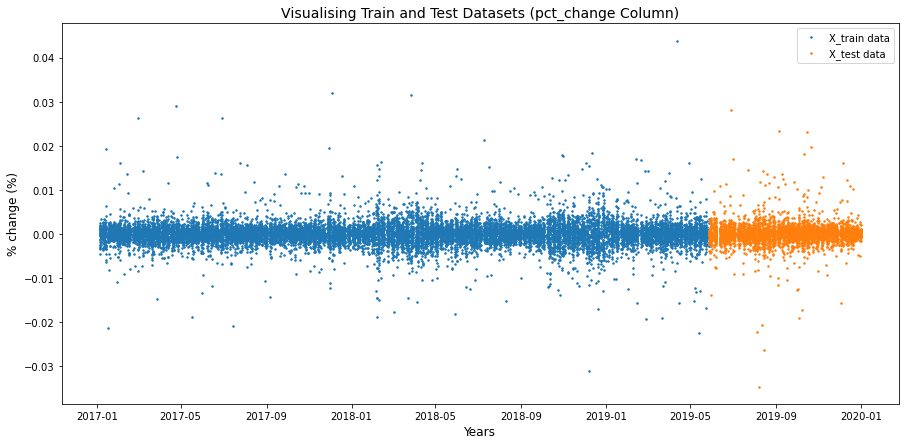

In [67]:
# Obtain the features and target for the `train_data` and `test_data` without shuffling
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.80, shuffle=False)

# Plot the data
plt.figure(figsize=(15, 7))

plt.plot(X_train['pct_change'], linestyle='None',
         marker='.', markersize=3.0, label='X_train data')
plt.plot(X_test['pct_change'], linestyle='None',
         marker='.', markersize=3.0, label='X_test data')

# Set the title and axis label
plt.title("Visualising Train and Test Datasets (pct_change Column)", fontsize=14)
plt.xlabel('Years', fontsize=12)
plt.ylabel('% change (%)', fontsize=12)

# Display the plot
plt.legend()
plt.show()

### Save the Files on Your Disk

In [68]:
# Save the files to disk
X_train.to_csv("JPM_features_training_2017_2019.csv")
X_test.to_csv("JPM_features_testing_2017_2019.csv")
y_train.to_csv("JPM_target_training_2017_2019.csv")
y_test.to_csv("JPM_target_testing_2017_2019.csv")

# 3. ML Classification Model Training and Forecasting

## Import Libraries

In [69]:
# For data manipulation
import pandas as pd

# Import sklearn's Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

## Read the Data

In [70]:
# Read the target and features of the training and testing data
X_train = pd.read_csv("JPM_features_training_2017_2019.csv", index_col=0, parse_dates=True)
X_test = pd.read_csv("JPM_features_testing_2017_2019.csv", index_col=0, parse_dates=True)
y_train = pd.read_csv("JPM_target_training_2017_2019.csv", index_col=0, parse_dates=True)
y_test = pd.read_csv("JPM_target_testing_2017_2019.csv", index_col=0, parse_dates=True)

## Select a Classification Model 

In [71]:
# Create the machine learning model
rf_model = RandomForestClassifier(
    n_estimators=3, max_features=3, max_depth=2, random_state=4)

## Train the Model 

In [72]:
# Fit the model on the training data
rf_model.fit(X_train, y_train['signal'])

RandomForestClassifier(max_depth=2, max_features=3, n_estimators=3,
                       random_state=4)

## Forecast Data

In [74]:
# Get a sample day of data from X_test
unseen_data_single_day = X_test.head(1)

# Preview the data
unseen_data_single_day

,pct_change,pct_change2,pct_change5,rsi,adx,corr,volatility
2019-05-28 12:00:00+00:00,0.0,-0.000091,0.001374,47.746053,26.139722,-0.515815,0.143024


In [75]:
# Get the prediction of a single day
single_day_prediction = rf_model.predict(unseen_data_single_day)

# Preview the prediction
single_day_prediction

array([0], dtype=int64)

In [76]:
# Use the model and predict the values for the test data
y_pred = rf_model.predict(X_test)

# Display the first five predictions
print("The first five predicted values", y_pred[:5])

The first five predicted values [0 0 1 0 0]


### Save the Files on Your Disk

In [77]:
# Save the predictions with the time index same as y_test
predicted_signal = pd.DataFrame(y_pred, index=y_test.index, columns=['signal'])
predicted_signal.to_csv("JPM_predicted_2017_2019.csv")

# 4. Metrics to Evaluate a Classifier

## Import Libraries

In [78]:
# For data manipulation
import pandas as pd

# Libraries for evaluating the model
from sklearn.metrics import classification_report, confusion_matrix

# Libraries for plotting
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-darkgrid')
import seaborn as sns
import matplotlib.colors as clrs

## Read the Data

In [79]:
# Read the model predicted target values
y_pred = pd.read_csv("JPM_predicted_2017_2019.csv",
                     index_col=0, parse_dates=True)['signal']

# Read the target values of the testing dataset
y_test = pd.read_csv("JPM_target_testing_2017_2019.csv",
                     index_col=0, parse_dates=True)['signal']

# 5. Accuracy

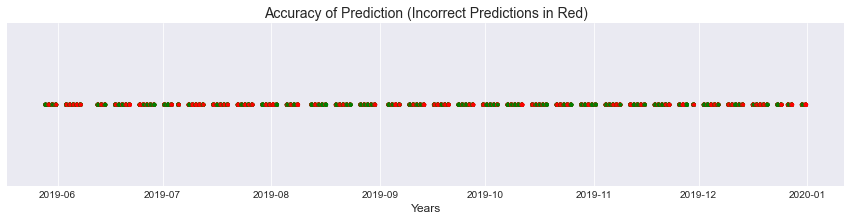

The accuracy is 51.55%.


In [80]:
# Define the accuracy data
accuracy_data = (y_pred == y_test)

# Accuracy percentage
accuracy_percentage = round(100 * accuracy_data.sum()/len(accuracy_data), 2)

# Plot the accuracy data
plt.figure(figsize=(15, 3))

# Colour mapping for the correct and incorrect predictions
cmap = clrs.ListedColormap(['green', 'red'])

plt.yticks([])
plt.scatter(x=y_test.index, y=[1]*len(y_test),
            c=(accuracy_data != True).astype(float), marker='.', cmap=cmap)

# Set the title and axis label
plt.title("Accuracy of Prediction (Incorrect Predictions in Red)", fontsize=14)
plt.xlabel('Years', fontsize=12)

# Display the results
plt.show()
print(f"The accuracy is {accuracy_percentage}%.")

## Confusion Matrix

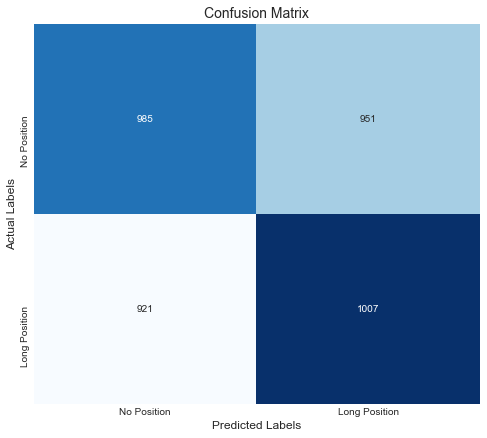

In [81]:
# Define the confusion matrix
confusion_matrix_data = confusion_matrix(y_test.values, y_pred.values)

# Plot the data
fig, ax = plt.subplots(figsize=(8, 7))
sns.heatmap(confusion_matrix_data, fmt="d",
            cmap='Blues', cbar=False, annot=True, ax=ax)

# Set the axes labels and the title
ax.set_xlabel('Predicted Labels', fontsize=12)
ax.set_ylabel('Actual Labels', fontsize=12)
ax.set_title('Confusion Matrix', fontsize=14)
ax.xaxis.set_ticklabels(['No Position', 'Long Position'])
ax.yaxis.set_ticklabels(['No Position', 'Long Position'])

# Display the plot
plt.show()

## Classification Report

In [82]:
# Classification report
classification_report_data = classification_report(y_test, y_pred)

# Print the classification report
print(classification_report_data)

              precision    recall  f1-score   support

           0       0.52      0.51      0.51      1936
           1       0.51      0.52      0.52      1928

    accuracy                           0.52      3864
   macro avg       0.52      0.52      0.52      3864
weighted avg       0.52      0.52      0.52      3864



# 6. Strategy Backtesting

## Import Libraries

In [83]:
# For data manipulation
import numpy as np
import pandas as pd

# For plotting
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-darkgrid')

## Read the Data

In [84]:
# Read the CSV file using read_csv method of pandas
strategy_data = pd.read_csv("JPM_predicted_2017_2019.csv", index_col=0)

# Read the close price
strategy_data['close'] = pd.read_csv("JPM_2017_2019.csv", index_col=0).loc[strategy_data.index[0]:]['close']
strategy_data.index = pd.to_datetime(strategy_data.index)

# Preview the strategy data
strategy_data.head()

,signal,close
2019-05-28 12:00:00+00:00,0,109.29
2019-05-28 12:15:00+00:00,0,109.37
2019-05-28 12:30:00+00:00,1,109.33
2019-05-28 12:45:00+00:00,0,109.37
2019-05-28 13:00:00+00:00,0,109.38


## Calculate Strategy Returns

In [85]:
# Calculate the percentage change
strategy_data['pct_change'] = strategy_data['close'].pct_change()

# Calculate the strategy returns
strategy_data['strategy_returns'] = strategy_data['signal'].shift(1) * \
    strategy_data['pct_change']

# Drop the missing values
strategy_data.dropna(inplace=True)

strategy_data.head()

,signal,close,pct_change,strategy_returns
2019-05-28 12:15:00+00:00,0,109.37,0.000732,0.000000
2019-05-28 12:30:00+00:00,1,109.33,-0.000366,-0.000000
2019-05-28 12:45:00+00:00,0,109.37,0.000366,0.000366
2019-05-28 13:00:00+00:00,0,109.38,0.000091,0.000000
2019-05-28 13:15:00+00:00,0,109.37,-0.000091,-0.000000


## Plot the Equity Curve

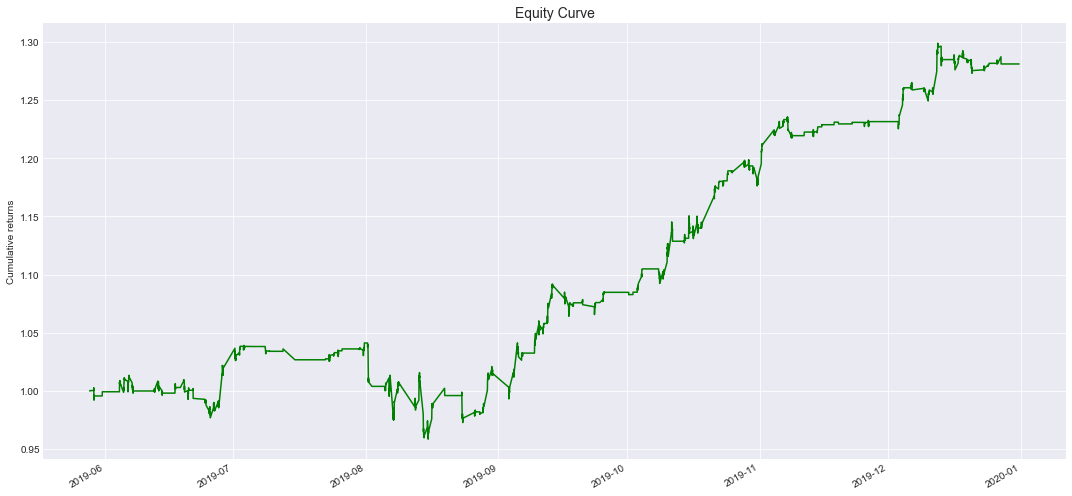

The cumulative return is 28.10%.


In [87]:
# Calculate the cumulative returns
strategy_data['cumulative_returns'] = (
    1+strategy_data['strategy_returns']).cumprod()

# ---------------------Equity Curve---------------------
# Plot cumulative strategy returns
strategy_data['cumulative_returns'].plot(figsize=(15, 7), color='green')
plt.title('Equity Curve', fontsize=14)
plt.ylabel('Cumulative returns')
plt.tight_layout()
plt.show()

cumulative_returns = (strategy_data['cumulative_returns'][-1] - 1)*100
print("The cumulative return is {0:.2f}%.".format(cumulative_returns))

## Performance Metrics

#### Annualised returns

In [88]:
# Calculate the annualised returns
annualised_return = ((strategy_data['cumulative_returns'][-1]) **
                    (252*6.5*4/strategy_data.shape[0]) - 1) * 100
print("The annualised return is {0:.2f}%.".format(annualised_return))

The annualised return is 52.20%.


#### Annualised volatility

In [89]:
# Calculate the annualised volatility
annualised_volatility = strategy_data['strategy_returns'].std()*np.sqrt(
    252*6.5*4) * 100
print("The annualised volatility is {0:.2f}%.".format(annualised_volatility))

The annualised volatility is 14.90%.


#### Maximum drawdown

The maximum drawdown is -7.94%.


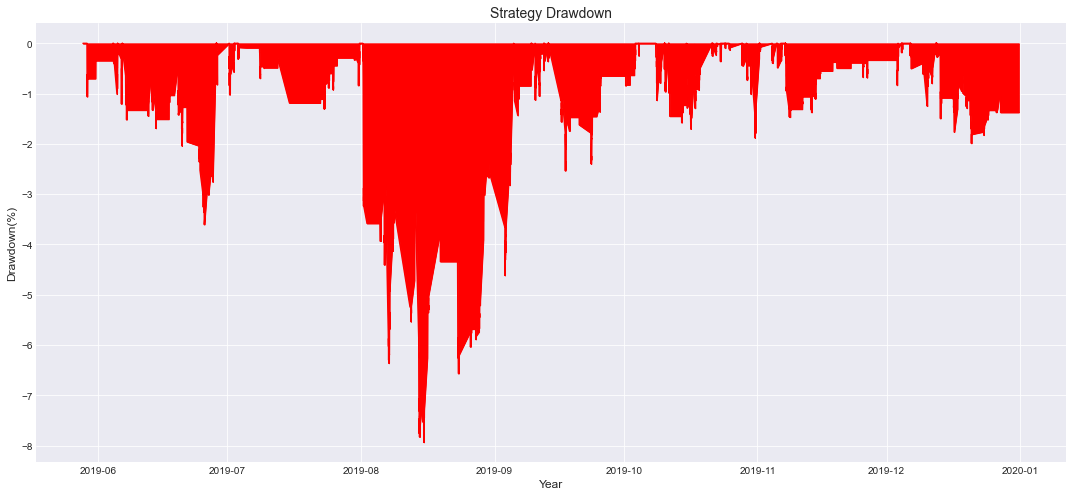

In [91]:
# Calculate the running maximum
running_max = np.maximum.accumulate(
    strategy_data['cumulative_returns'].dropna())
# Ensure the value never drops below 1
running_max[running_max < 1] = 1
# Calculate the percentage drawdown
drawdown = ((strategy_data['cumulative_returns'])/running_max - 1) * 100

# Calculate the maximum drawdown
max_dd = drawdown.min()
print("The maximum drawdown is {0:.2f}%.".format(max_dd))

# ---------------------DD plot---------------------
fig = plt.figure(figsize=(15, 7))

# Plot max drawdown
plt.plot(drawdown, color='red')
# Fill in-between the drawdown
plt.fill_between(drawdown.index, drawdown.values, color='red')
plt.title('Strategy Drawdown', fontsize=14)
plt.ylabel('Drawdown(%)', fontsize=12)
plt.xlabel('Year', fontsize=12)

plt.tight_layout()
plt.show()

#### Sharpe Ratio

In [92]:
# Calculate the Sharpe ratio
sharpe_ratio = round(strategy_data['strategy_returns'].mean() /
                     strategy_data['strategy_returns'].std() * np.sqrt(252*6.5*4), 2)
print("The Sharpe ratio is {0:.2f}.".format(sharpe_ratio))

The Sharpe ratio is 2.89.
